In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# The Model

The input (or forcing ) to the carbon cycle model are annual emissions of $CO_2$ , measured in Mt C (megatonne carbon = million metric tonnes of carbon). 1 The output of the carbon cycle model is the atmospheric concentration of $CO_2$ , measured in ppm (parts per million by volume).

The input (or forcing) to the climate model is the atmospheric concentration of carbon dioxide, again measured in ppm. The output of the climate dynamics model is the yearly average temperature increase over pre-industrial temperatures in . 

The two components are coupled via the atmospheric concentration of $CO_2$ , i.e., the output of the carbon cycle model is an input to the climate dynamics model.

In [2]:
from IPython import display
display.Image("/Users/danypineault/Documents/Book/book/image/IAM.jpg")

FileNotFoundError: No such file or directory: '/Users/danypineault/Documents/Book/book/image/IAM.jpg'

FileNotFoundError: No such file or directory: '/Users/danypineault/Documents/Book/book/image/IAM.jpg'

<IPython.core.display.Image object>

The model will run in yearly time steps. It will start in 1750 and end in 2300.

## Carbon cycle module

The carbon cycle model is a five-box model. The five boxes do not correspond to anything in the physical world; they are a mathematical abstraction that as a whole mimics the results from much more complicated models. In this model, all atmospheric $CO_2$ concentrations live in one of five boxes. If you want to compute the total atmospheric $CO_2$ concentration at any point in time, you add the amount of $CO_2$ in the five boxes. Over time, $CO_2$ disappears from all of these boxes, at different rates for each individual box. New anthropogenic $CO_2$ emissions are added every year to the atmosphere. 

In the five-box model these yearly influxes of new $CO_2$ are distributed by fixed shares into the five boxes: 13% go into the first box, 20% into the second, 32% into the third, 25% into the fourth and the remaining 10% into the fifth box. There are consequently five variables that represent the five boxes and each of these variables takes on a different value in each year. 

The equation that is used to compute the amount of $CO_2$ in box i (which takes values from 1 to 5) at time t (which takes on values from 1750 to 2020) is:

\begin{align}
L_{i, t} = (1-\delta_i) L_{i, t-1} + \nu_i \chi M^*_{t-1}
\end{align}

where:
- Variable $L_{i,t}$ is the atmospheric load, the amount of $CO_2$ in box $i$ at time $t$, measured in ppm
- Parameter $\delta_i$ is the degradation rate, the share of $CO_2$ that disappears each year from box $i$ 
- $1 − δ$ i is the share of $CO_2$ in box $i$ that stays in the atmosphere until the next time period
- $\nu_i$ i is the share of emissions that goes into box $i$
- $\chi$ is a unit conversion factor: $CO_2$ emissions in our model are measured in $Mt C$, but atmospheric $CO_2$ concentrations are measured in ppm: $\chi$ converts from the unit $Mt C$ to $CO_2$ ppm
- $M^∗_t$ are world total emissions of $CO_2$ in year $t$, measured in $Mt C$.

Equation (13.1) is a difference equation, that is, for the first year only, you should not use Equation (13.1), but instead use initial values: $L_{i,1750}=0$ except $L_{1,1750} = 275$.

The final step in the carbon cycle model is to compute atmospheric $CO_2$ concentrations at each point in time:
\begin{align}
L_t = \sum_{i=1}^5 L_{i,t} = L_{1,t}+L_{2,t}+L_{3,t}+L_{4,t}+L_{5,t}
\end{align}
where:
- $L_t$ is the atmospheric concentration of $CO_2$ at time $t$ , it is the sum of the five boxes at that time.

## Climate module 

The climate model has two parts: the first part computes the extra energy in the atmosphere and the long term temperature effect. The second part computes the yearly temperature increase over time. 

### Extra energy in the atmosphere

The amount of extra energy caused by rising $CO_2$ concentrations is called the radiative forcing and is measured in Watts per square metre, $Wm^{−2}$. The equation to compute this variable is 

\begin{align}
F_t = 5.35 \ln (\frac{C_t}{C_{pre}})
\end{align}

$F_t$ is the radiative forcing at time t caused by $CO_2$ in $Wm^{−2}$

$C_t$ is the atmospheric $CO_2$ concentration at point t in ppm, as computed by the previous component. 

$C_{pre}$ is the preindustrial level of atmospheric $CO_2$ concentrations, and we use 275 ppm for this. 

## Long term temperature effect

The next step in the model is to global mean surface air temperature. The equation for that is 

\begin{align}
T^A_t = T^A_{t-1} + \psi_1(\psi_2 F_t - T^A_{t-1}) + \psi_3(T^O_{t-1}-T^A_{t-1})
\end{align}

where:

- $T^A_t$ is the increase in global average surface temperature
- $\psi_2 = 1.15$ is a parameter
- $5.35 \psi_2 ln(2) = 4.26$ is the climate sensitivity, the equilibrium warming due to a doubling of the atmospheric concentration of carbon dioxide
- $\psi_1 = 0.0256$ is a parameter that determines how fast the atmosphere responds to a deviation between the actual and the equilibrium temperature
- $\psi_3 = 0.00738$ is a parameter that determines how fast the atmosphere responds to a deviation between the temperature of the atmosphere and ocean

$T^O_t$ is the temperature of the ocean, which follows:
\begin{align}
T^O_t = T^O_{t-1} + \psi_4(T^A_{t-1}-T^O_{t-1})
\end{align}
where 
- $\psi_4 = 0.00568$ is a parameter that determines how fast the ocean responds to a deviation between the temperature of the atmosphere and ocean.


The temperatures of atmosphere and ocean are government by a system of coupled difference equations. The ocean’s temperature depends on its own past and on the atmosphere’s past, and so does the atmosphere’s temperature. We therefore need to initialize the temperatures for the year 1850. The initialization is $T^A_{1850} = T^O_{1850} = 0$. As a result, our model yields temperature anomalies , that is, warming relative to pre-industrial times.

## Python formulation

### Emissions

For now, we will take emissions as given. Let download the six scenarios:

In [3]:
file = "/Users/danypineault/Documents/Book/book/data/EmissionScenarios.csv"
scenarios_emissions = pd.read_csv(file)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/danypineault/Documents/Book/book/data/EmissionScenarios.csv'

## Carbon cycle module

Let represent the function $L_t$ as

In [372]:
def atmos_load(t_span, L_init, delta, share_emit, conv_fact, tot_emit):
    L = np.zeros((len(t_span), 6))
    
    for i in range(5): 
        L[0,i+1] = L_init[i]
        for t in t_span[1:]:  
            L[t, i+1] = (1 - delta[i]) * L[t-1, i+1] + share_emit[i] * conv_fact * tot_emit[t-1]
            
    L[0,0] = 275
    for t2 in t_span[1:]:  
        L[t2,0] = L[0,0] + L[t2,1]+L[t2,2]+L[t2,3]+L[t2,4]+L[t2,5]
    
    return L

## Climate module 

Let represent the forcing function $F_t$ as

In [473]:
def eval_forcing(Ct, Cpre):
    return 5.35 * np.log(Ct / Cpre)

and the global mean surface air temperature $T^A$ as

In [474]:
def eval_T(t_span, t_init, chis, forcing):
    Ta = np.zeros(len(t_span))
    To = np.zeros(len(t_span))
    [chi1, chi2, chi3, chi4] = chis

    for t in t_span:
        if t<=100:
            Ta[t] = 0.
            To[t] = 0.
        else:
            Ta[t] = Ta[t-1] + chi1 * (chi2 * forcing[t] - Ta[t-1]) + chi3 * (To[t-1] - Ta[t-1])
            To[t] = To[t-1] + chi4 * (Ta[t-1] -To[t-1])
    return (Ta, To)

In [481]:
def plot_scens(x, title, scens, names, max):
    fig = go.Figure()
    fig.update_layout(
        height=500, title=title
    )
    i=0
    for s in scens:
        fig.add_trace(go.Scatter(x=s.Year[200:], y=s[x][200:],
                            mode='lines',
                            name="{}".format(names[i])))
        i+=1

    fig.update_yaxes(range=[0, max])
    fig.show()
    print("")

In [482]:
def run(scen_emission):
    t_span = np.arange(0, scen_emission.size, 1)
    
    L_init = [0.0, 0.0, 0.0, 0.0, 0.0]
    share_emit = [0.13, 0.20, 0.320, 0.25, 0.10]
    deltas = [0., 1 - np.exp(-1/363),1 - np.exp(-1/74),1-  np.exp(-1/17),1 - np.exp(-1/2)]
    t_init = [0.0, 0.0]
    chis = [0.0256, 1.148910335, 0.00738, 0.00568]
    
    conv_fact =  0.00047
    concentration = atmos_load(t_span, L_init, deltas, share_emit, conv_fact, scen_emission)
    forcing = eval_forcing(concentration[:,0], concentration[0,0])
    ta, to = eval_T(t_span, t_init, chis, forcing)
    
    data = {
            "Year": t_span+1750,
            "Emission": scen_emission,
            "Concentration": concentration[:,0],
            "Box1": concentration[:,1],
            "Box2": concentration[:,2],
            "Box3": concentration[:,3],
            "Box4": concentration[:,4],
            "Box5": concentration[:,5],
            "Forcing": forcing,
            "TempAtmos": ta,
            "TempOcean": to
        }
        
    idx = pd.Index(t_span, name='Time')
    res = pd.DataFrame(data, index=idx)
    return res

In [483]:
scen_1a = run(scenarios_emissions["s1aConstant"].to_numpy())
scen_1b = run(scenarios_emissions["s1bPlus2"].to_numpy())
scen_2a = run(scenarios_emissions["s2a236pct"].to_numpy())
scen_2b = run(scenarios_emissions["s2b529pct"].to_numpy())
scen_3a = run(scenarios_emissions["s3a375pct"].to_numpy())
scen_3b = run(scenarios_emissions["s3b196pct"].to_numpy())
scens = [scen_1a, scen_1b, scen_2a, scen_2b, scen_3a, scen_3b]
names = ["scen_1a", "scen_1b", "scen_2a", "scen_2b", "scen_3a", "scen_3b"]

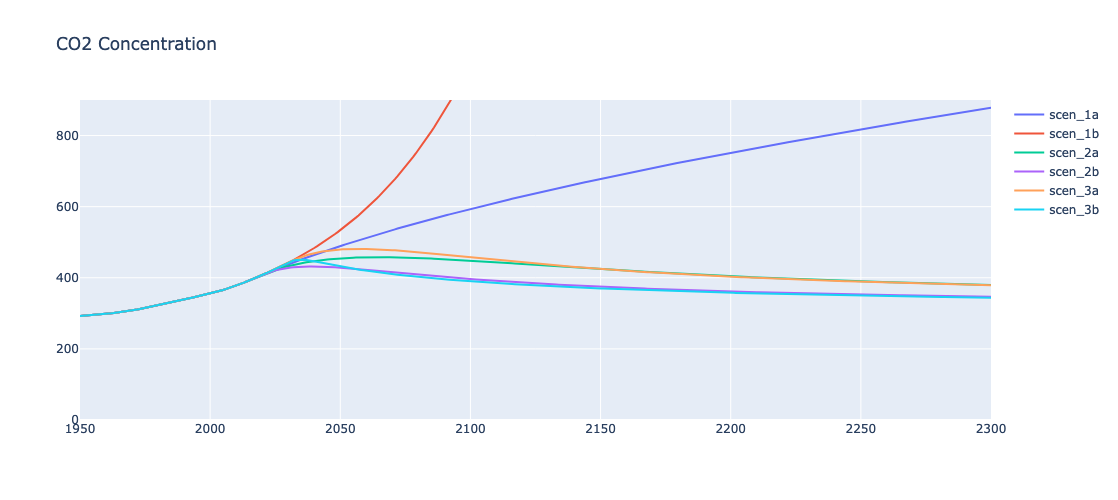

In [484]:
draw_scens("Concentration", "CO2 Concentration", scens, names, 900)

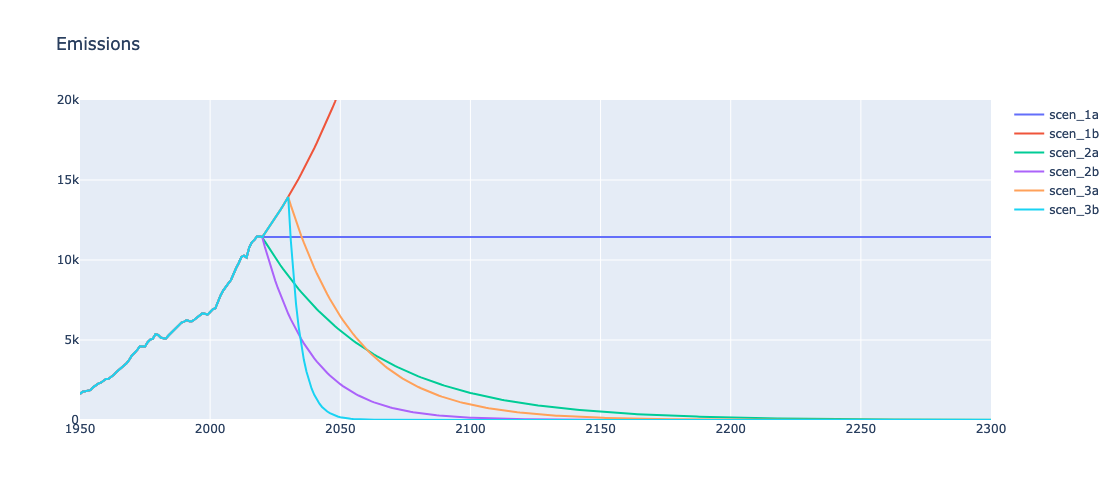

In [485]:
draw_scens("Emission", "Emissions", scens, names, 20000)

In [480]:
draw_scens("TempAtmos", "Temperature", scens, names, 6)

KeyError: 'Temperature'

## Economics Module

In [3]:
file_econ = "/Users/danypineault/Documents/Book/book/data/econData.csv"
df_econ = pd.read_csv(file_econ)

In [4]:
df_econ

,Year,PopRich,PopMiddle,PopPoor,PopGRich,PopGMiddle,PopGPoor,GDPRich,GDPMiddle,GDPPoor,EnergyRich,EnergyMiddle,EnergyPoor,CO2Rich,CO2Middle,CO2Poor
0,NaN,NaN,NaN,NaN,0.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1960.0,755.0,1194.0,1067.0,NaN,NaN,NaN,7556.0,833.0,262.0,1823.0,NaN,NaN,5170.0,2633.0,321.0
2,1961.0,765.0,1200.0,1092.0,1.40%,0.45%,2.38%,7939.0,859.0,272.0,1870.0,NaN,NaN,5281.0,2464.0,345.0
3,1962.0,774.0,1218.0,1119.0,1.20%,1.49%,2.41%,8405.0,889.0,283.0,1971.0,NaN,NaN,5523.0,2463.0,364.0
4,1963.0,783.0,1247.0,1146.0,1.15%,2.40%,2.44%,8839.0,906.0,301.0,2097.0,NaN,NaN,5836.0,2591.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2016.0,1125.0,2729.0,3775.0,0.47%,1.19%,2.66%,39054.0,11921.0,4050.0,4986.0,6511.0,2077.0,11853.0,21558.0,4657.0
58,2017.0,1131.0,2762.0,3873.0,0.59%,1.22%,2.60%,39594.0,12569.0,3918.0,4973.0,6742.0,2111.0,11719.0,22218.0,4413.0
59,2018.0,1138.0,2795.0,3973.0,0.59%,1.21%,2.57%,40190.0,13259.0,4051.0,4990.0,6886.0,2354.0,11810.0,22818.0,3939.0
60,2019.0,1145.0,2829.0,4075.0,0.60%,1.20%,2.57%,41056.0,13913.0,4228.0,4982.0,7096.0,2258.0,11625.0,23072.0,4098.0
